<a href="https://colab.research.google.com/github/AlirezaSM/template-matching/blob/main/template_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/cplusx/QATM.git

Cloning into 'QATM'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 9.19 MiB | 19.28 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [3]:
!7z x drive/MyDrive/Dataset.7z -o.


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 5359681573 bytes (5112 MiB)

Extracting archive: drive/MyDrive/Dataset.7z
--
Path = drive/MyDrive/Dataset.7z
Type = 7z
Physical Size = 5359681573
Headers Size = 279463
Method = LZMA2:24
Solid = +
Blocks = 3

  0%      0% 1        0% 11 - Dataset/Sample0004_Image.png                                        0% 23 - Dataset/Sample0008_Image.png                                        0% 35 - Dataset/Sample0012_Image.png                                        0% 44 - Dataset/Sam

# Using QATM for template matching

In [1]:
from __future__ import print_function, division

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, sys

In [3]:
import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Concatenate
from keras import Model
import keras.backend as K
from keras.applications.vgg16 import preprocess_input
import progressbar

In [4]:
print(keras.__version__, tf.__version__)

2.9.0 2.9.2


In [5]:
from QATM.models import QATM, MyNormLayer
from QATM.utils import compute_score, all_sample_iou, plot_success_curve

In [ ]:
# file_dir = 'QATM/data'
# gt = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir)  if '.txt' in i ])
# img_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if '.jpg' in i ] )
# def read_gt( file_path ):
#     with open( file_path ) as IN:
#         x, y, w, h = [ eval(i) for i in IN.readline().strip().split(',')]
#     return x, y, w, h

In [6]:
file_dir = 'Dataset'
gt = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir)  if '.txt' in i ])
img_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if 'Image.png' in i ] )
tmp_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if 'Template.png' in i ] )

gt = gt[:100]
img_path = img_path[:100]
tmp_path = tmp_path[:100]


def read_gt( file_path ):
    with open( file_path ) as IN:
        xmin, ymin, xmax, ymax = [ eval(i) for i in IN.readline().strip().split(',')]
        w = xmax - xmin
        h = ymax - ymin
    return xmin, ymin, w, h

In [7]:
def create_model( featex, alpha = 1. ):
    T = Input( (None, None, 3), name='template_input' )
    I = Input( (None, None, 3), name='image_input' )
    T_feat = featex(T)
    I_feat = featex(I)
    I_feat, T_feat = MyNormLayer( name='norm_layer' )( [I_feat, T_feat] )
    dist = Lambda( lambda x: tf.einsum( "xabc,xdec->xabde", K.l2_normalize(x[0], axis=-1), K.l2_normalize(x[1], axis=-1) ) , name="cosine_dist")([ I_feat, T_feat ])
    conf_map = QATM(alpha, name='qatm')( dist )
    return Model( [T, I], [conf_map], name='QATM_model' )
    
def model_eval( featex, alpha=1., backup=None ):
    '''
    Have a backup featex in case image is too big.
    '''
    model = create_model( featex , alpha=alpha)
    if backup is not None:
        model_bkup = create_model( backup , alpha=alpha)
    else:
        model_bkup = model
    gt_list, gray_list, score_list = [], [], []

    # num_samples = len(img_path) // 2
    # bar = progressbar.ProgressBar(max_value=num_samples)
    # for idx in range(num_samples):
    #     bar.update(idx + 1)
    #     # load image and ground truth
    #     template_raw = cv2.imread( img_path[2*idx] )[...,::-1]
    #     template_bbox = read_gt( gt[2*idx] )
    #     x, y, w, h = [int(round(t)) for t in template_bbox]
    #     template = template_raw[y:y+h, x:x+w]
    #     image = cv2.imread( img_path[2*idx+1] )[...,::-1]
    #     image_gt = read_gt( gt[2*idx+1] )
    #     x_gt, y_gt, w_gt, h_gt = [int(round(t)) for t in image_gt]

    num_samples = len(img_path)
    bar = progressbar.ProgressBar(max_value=num_samples)
    print('NUM SAMPLE', num_samples)
    for idx in range(num_samples):
        bar.update(idx + 1)
        # load image and ground truth
        template = cv2.imread( tmp_path[idx] )[...,::-1]
        image = cv2.imread( img_path[idx]) [...,::-1]
        image_gt = read_gt( gt[idx] )
        print('SHAPES', template.shape, image.shape, image_gt)
        x_gt, y_gt, w_gt, h_gt = [int(round(t)) for t in image_gt]
        print('XYWH', x_gt, y_gt, w_gt, h_gt)
        w = image.shape[0]
        h = image.shape[1]


        # process images
        template_ = np.expand_dims(preprocess_input( template ), axis=0)
        image_ = np.expand_dims(preprocess_input( image ) , axis=0)
        print('SHAPES AFTER EXPAND', template_.shape, image_.shape)
        print('W, H', w, h)
        if w*h <= 130000:
            val = model.predict( [template_, image_] )
            # plt.figure()
            # plt.imshow(np.squeeze(np.log(val)))
            # plt.show()
        else:
            # used when image is too big
            val = model_bkup.predict( [template_, image_] )
        
        # compute geometry mean on score map
        print('SALAM')
        val = np.log( val )
        gray = val[0,:,:,0]
        gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
        print('SHAPE AFTER RESIZE', gray.shape)
        score = compute_score( gray, w_gt, h_gt )
        print('SCORE SHAPE', score.shape)
        
        score[score>-1e-7] = -np.inf
        plt.figure()
        plt.imshow(score)
        plt.show()
        
        gt_list.append( image_gt )
        gray_list.append( gray )
        score_list.append( score )
    return score_list, gt_list, gray_list

In [8]:
vgg19 = keras.applications.vgg19.VGG19( include_top = False, weights = 'imagenet' )

In [9]:
# resize conv3_4 to conv1_2
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv3_4 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[0], size=(tf.shape(x[1])[1], tf.shape(x[1])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex = Model( [input_], [concat], name='featex' )
# resize conv1_2 to conv3_4, used when image size is too big
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv1_2 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[1], size=(tf.shape(x[0])[1], tf.shape(x[0])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex2 = Model( [input_], [concat], name='featex2' )

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

NUM SAMPLE 100
SHAPES (47, 31, 3) (721, 1281, 3) (1147, 0, 31, 37)
XYWH 1147 0 31 37
SHAPES AFTER EXPAND (1, 47, 31, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 6s 6s/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


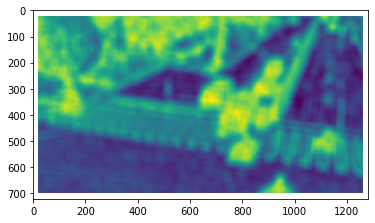

  2% (2 of 100) |                        | Elapsed Time: 0:00:09 ETA:   0:07:40

SHAPES (62, 40, 3) (721, 1281, 3) (199, 154, 79, 41)
XYWH 199 154 79 41
SHAPES AFTER EXPAND (1, 62, 40, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 1s 1s/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


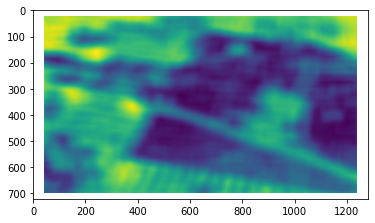

  3% (3 of 100) |                        | Elapsed Time: 0:00:18 ETA:   0:14:33

SHAPES (62, 40, 3) (721, 1281, 3) (312, 181, 79, 43)
XYWH 312 181 79 43
SHAPES AFTER EXPAND (1, 62, 40, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 317ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


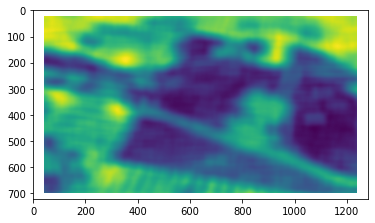

  4% (4 of 100) |                        | Elapsed Time: 0:00:23 ETA:   0:08:56

SHAPES (62, 40, 3) (721, 1281, 3) (55, 106, 73, 47)
XYWH 55 106 73 47
SHAPES AFTER EXPAND (1, 62, 40, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 261ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


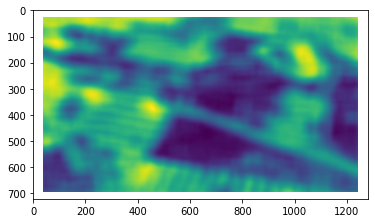

  5% (5 of 100) |#                       | Elapsed Time: 0:00:28 ETA:   0:07:54

SHAPES (62, 40, 3) (721, 1281, 3) (101, 125, 73, 47)
XYWH 101 125 73 47
SHAPES AFTER EXPAND (1, 62, 40, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 268ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


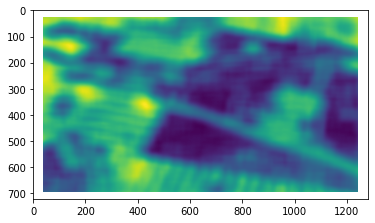

  6% (6 of 100) |#                       | Elapsed Time: 0:00:34 ETA:   0:07:59

SHAPES (48, 32, 3) (721, 1281, 3) (772, 117, 79, 58)
XYWH 772 117 79 58
SHAPES AFTER EXPAND (1, 48, 32, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 368ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


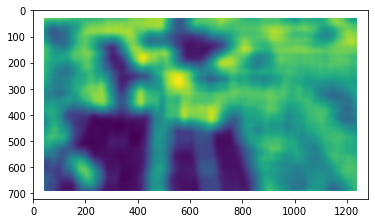

  7% (7 of 100) |#                       | Elapsed Time: 0:00:41 ETA:   0:10:54

SHAPES (112, 69, 3) (721, 1281, 3) (1004, 164, 47, 68)
XYWH 1004 164 47 68
SHAPES AFTER EXPAND (1, 112, 69, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 443ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


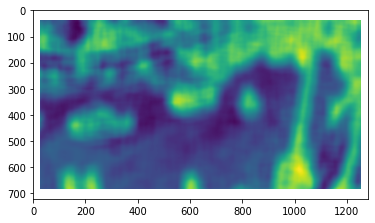

  8% (8 of 100) |#                       | Elapsed Time: 0:00:46 ETA:   0:07:39

SHAPES (59, 64, 3) (721, 1281, 3) (616, 225, 93, 58)
XYWH 616 225 93 58
SHAPES AFTER EXPAND (1, 59, 64, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 397ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


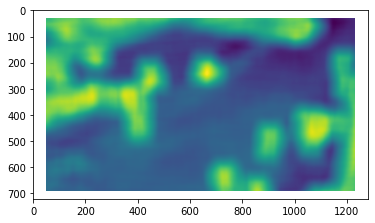

  9% (9 of 100) |##                      | Elapsed Time: 0:00:53 ETA:   0:11:54

SHAPES (137, 69, 3) (721, 1281, 3) (813, 317, 58, 101)
XYWH 813 317 58 101
SHAPES AFTER EXPAND (1, 137, 69, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 1s 634ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


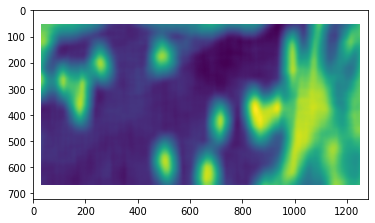

 10% (10 of 100) |##                     | Elapsed Time: 0:01:02 ETA:   0:13:13

SHAPES (61, 49, 3) (721, 1281, 3) (987, 73, 41, 60)
XYWH 987 73 41 60
SHAPES AFTER EXPAND (1, 61, 49, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 376ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


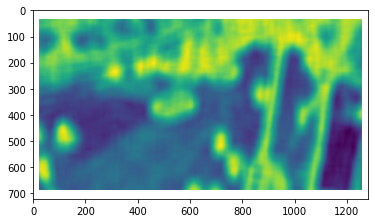

 11% (11 of 100) |##                     | Elapsed Time: 0:01:06 ETA:   0:05:45

SHAPES (136, 69, 3) (721, 1281, 3) (1158, 492, 72, 137)
XYWH 1158 492 72 137
SHAPES AFTER EXPAND (1, 136, 69, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 401ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


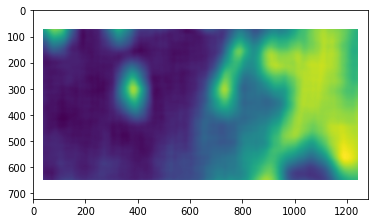

 12% (12 of 100) |##                     | Elapsed Time: 0:01:22 ETA:   0:23:51

SHAPES (32, 42, 3) (721, 1281, 3) (586, 381, 75, 58)
XYWH 586 381 75 58
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 352ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


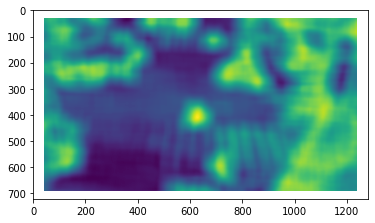

 13% (13 of 100) |##                     | Elapsed Time: 0:01:30 ETA:   0:11:06

SHAPES (63, 48, 3) (721, 1281, 3) (100, 348, 66, 79)
XYWH 100 348 66 79
SHAPES AFTER EXPAND (1, 63, 48, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 341ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


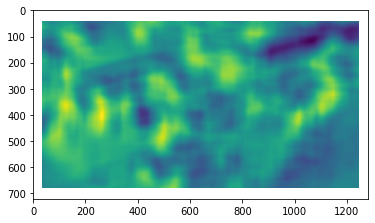

 14% (14 of 100) |###                    | Elapsed Time: 0:01:38 ETA:   0:10:55

SHAPES (50, 72, 3) (721, 1281, 3) (510, 198, 73, 50)
XYWH 510 198 73 50
SHAPES AFTER EXPAND (1, 50, 72, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 386ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


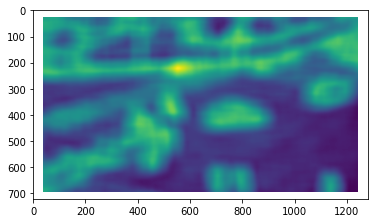

 15% (15 of 100) |###                    | Elapsed Time: 0:01:43 ETA:   0:07:49

SHAPES (43, 32, 3) (721, 1281, 3) (153, 649, 61, 63)
XYWH 153 649 61 63
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 364ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


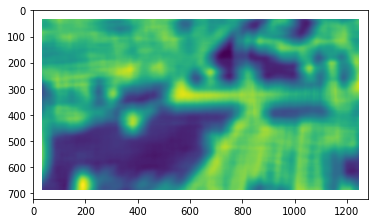

 16% (16 of 100) |###                    | Elapsed Time: 0:01:49 ETA:   0:08:03

SHAPES (32, 42, 3) (721, 1281, 3) (533, 334, 75, 48)
XYWH 533 334 75 48
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 259ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


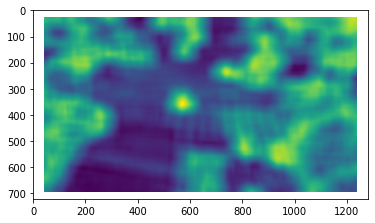

 17% (17 of 100) |###                    | Elapsed Time: 0:01:54 ETA:   0:07:23

SHAPES (56, 83, 3) (721, 1281, 3) (881, 236, 68, 58)
XYWH 881 236 68 58
SHAPES AFTER EXPAND (1, 56, 83, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 394ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


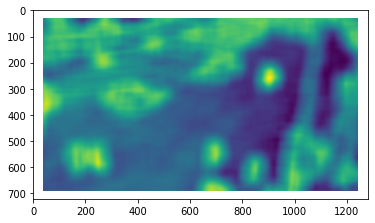

 18% (18 of 100) |####                   | Elapsed Time: 0:02:00 ETA:   0:08:05

SHAPES (70, 104, 3) (721, 1281, 3) (14, 388, 103, 68)
XYWH 14 388 103 68
SHAPES AFTER EXPAND (1, 70, 104, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 423ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


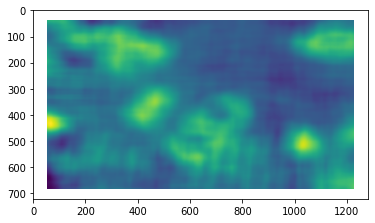

 19% (19 of 100) |####                   | Elapsed Time: 0:02:11 ETA:   0:14:09

SHAPES (65, 57, 3) (721, 1281, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 402ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


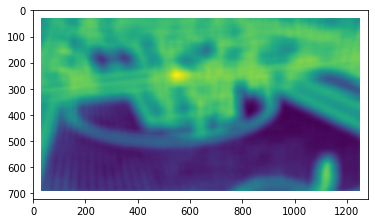

 20% (20 of 100) |####                   | Elapsed Time: 0:02:16 ETA:   0:06:25

SHAPES (103, 97, 3) (721, 1281, 3) (912, 284, 65, 79)
XYWH 912 284 65 79
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 441ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


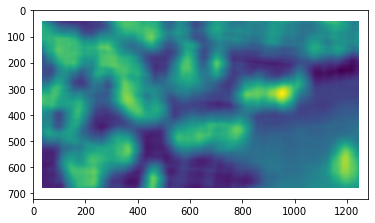

 21% (21 of 100) |####                   | Elapsed Time: 0:02:23 ETA:   0:10:05

SHAPES (43, 32, 3) (721, 1281, 3) (184, 623, 53, 61)
XYWH 184 623 53 61
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 270ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


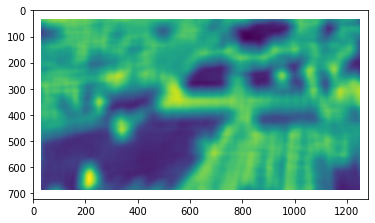

 22% (22 of 100) |#####                  | Elapsed Time: 0:02:28 ETA:   0:06:18

SHAPES (33, 41, 3) (721, 1281, 3) (632, 204, 74, 49)
XYWH 632 204 74 49
SHAPES AFTER EXPAND (1, 33, 41, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 308ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


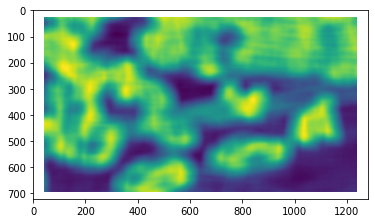

 23% (23 of 100) |#####                  | Elapsed Time: 0:02:33 ETA:   0:06:56

SHAPES (50, 97, 3) (721, 1281, 3) (493, 415, 93, 56)
XYWH 493 415 93 56
SHAPES AFTER EXPAND (1, 50, 97, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 393ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


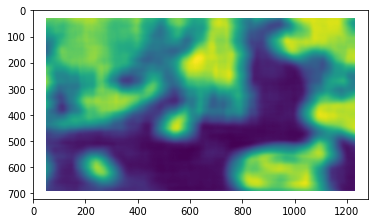

 24% (24 of 100) |#####                  | Elapsed Time: 0:02:41 ETA:   0:09:47

SHAPES (63, 48, 3) (721, 1281, 3) (31, 377, 81, 97)
XYWH 31 377 81 97
SHAPES AFTER EXPAND (1, 63, 48, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 291ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


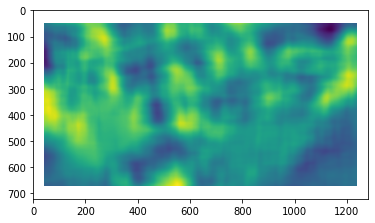

 25% (25 of 100) |#####                  | Elapsed Time: 0:02:53 ETA:   0:14:14

SHAPES (32, 47, 3) (721, 1281, 3) (310, 557, 59, 35)
XYWH 310 557 59 35
SHAPES AFTER EXPAND (1, 32, 47, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 365ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


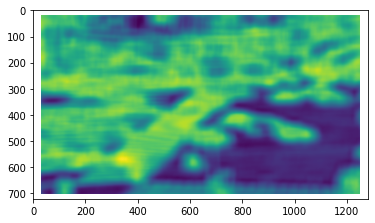

 26% (26 of 100) |#####                  | Elapsed Time: 0:02:56 ETA:   0:04:06

SHAPES (58, 100, 3) (721, 1281, 3) (852, 476, 100, 61)
XYWH 852 476 100 61
SHAPES AFTER EXPAND (1, 58, 100, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 409ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


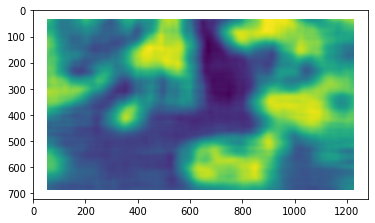

 27% (27 of 100) |######                 | Elapsed Time: 0:03:05 ETA:   0:10:45

SHAPES (63, 48, 3) (721, 1281, 3) (118, 336, 65, 79)
XYWH 118 336 65 79
SHAPES AFTER EXPAND (1, 63, 48, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 277ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


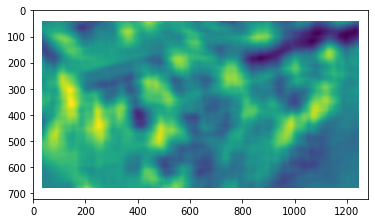

 28% (28 of 100) |######                 | Elapsed Time: 0:03:12 ETA:   0:08:50

SHAPES (103, 97, 3) (721, 1281, 3) (855, 294, 55, 81)
XYWH 855 294 55 81
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 313ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


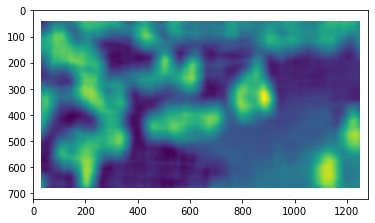

 28% (29 of 100) |######                 | Elapsed Time: 0:03:19 ETA:   0:07:45

SHAPES (32, 42, 3) (721, 1281, 3) (663, 440, 87, 58)
XYWH 663 440 87 58
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 267ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


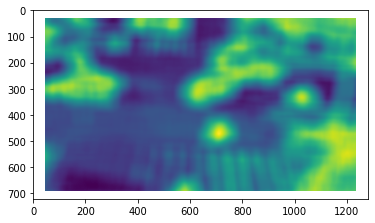

 30% (30 of 100) |######                 | Elapsed Time: 0:03:26 ETA:   0:08:27

SHAPES (136, 69, 3) (721, 1281, 3) (956, 447, 65, 130)
XYWH 956 447 65 130
SHAPES AFTER EXPAND (1, 136, 69, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 321ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


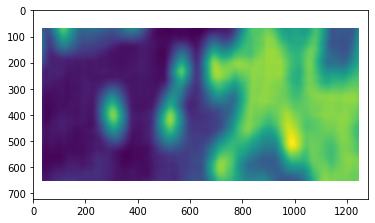

 31% (31 of 100) |#######                | Elapsed Time: 0:03:38 ETA:   0:14:08

SHAPES (50, 72, 3) (721, 1281, 3) (864, 213, 74, 50)
XYWH 864 213 74 50
SHAPES AFTER EXPAND (1, 50, 72, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 288ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


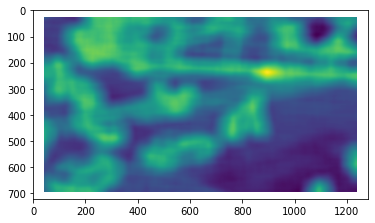

 32% (32 of 100) |#######                | Elapsed Time: 0:03:44 ETA:   0:06:16

SHAPES (64, 84, 3) (721, 1281, 3) (436, 630, 97, 79)
XYWH 436 630 97 79
SHAPES AFTER EXPAND (1, 64, 84, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 412ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


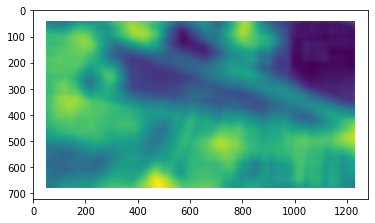

 33% (33 of 100) |#######                | Elapsed Time: 0:03:55 ETA:   0:12:22

SHAPES (32, 42, 3) (721, 1281, 3) (560, 358, 75, 53)
XYWH 560 358 75 53
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 295ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


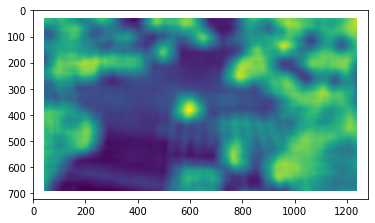

 34% (34 of 100) |#######                | Elapsed Time: 0:04:01 ETA:   0:06:23

SHAPES (118, 84, 3) (721, 1281, 3) (839, 296, 64, 94)
XYWH 839 296 64 94
SHAPES AFTER EXPAND (1, 118, 84, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 449ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


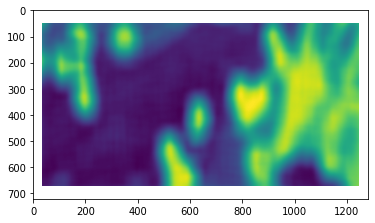

 35% (35 of 100) |########               | Elapsed Time: 0:04:10 ETA:   0:09:34

SHAPES (122, 72, 3) (721, 1281, 3) (509, 304, 50, 89)
XYWH 509 304 50 89
SHAPES AFTER EXPAND (1, 122, 72, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 438ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


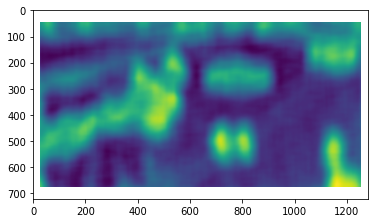

 36% (36 of 100) |########               | Elapsed Time: 0:04:16 ETA:   0:07:07

SHAPES (103, 97, 3) (721, 1281, 3) (775, 295, 55, 81)
XYWH 775 295 55 81
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 284ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


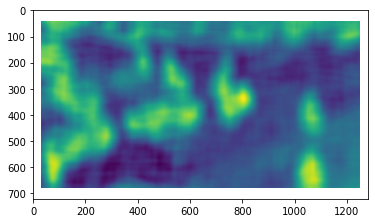

 37% (37 of 100) |########               | Elapsed Time: 0:04:23 ETA:   0:06:47

SHAPES (43, 32, 3) (721, 1281, 3) (199, 612, 49, 59)
XYWH 199 612 49 59
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 261ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


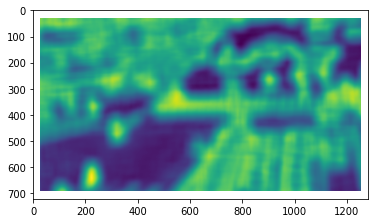

 38% (38 of 100) |########               | Elapsed Time: 0:04:27 ETA:   0:04:31

SHAPES (65, 57, 3) (721, 1281, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 269ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


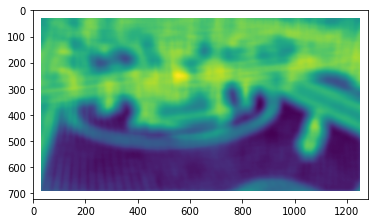

 39% (39 of 100) |########               | Elapsed Time: 0:04:31 ETA:   0:04:30

SHAPES (64, 84, 3) (721, 1281, 3) (471, 583, 87, 56)
XYWH 471 583 87 56
SHAPES AFTER EXPAND (1, 64, 84, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 267ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


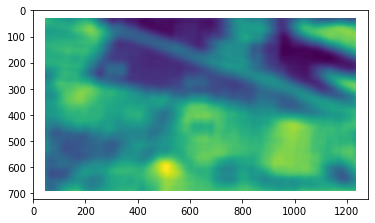

 40% (40 of 100) |#########              | Elapsed Time: 0:04:39 ETA:   0:07:09

SHAPES (32, 42, 3) (721, 1281, 3) (624, 409, 80, 59)
XYWH 624 409 80 59
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 277ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


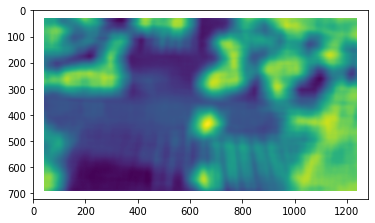

 41% (41 of 100) |#########              | Elapsed Time: 0:04:46 ETA:   0:06:47

SHAPES (103, 97, 3) (721, 1281, 3) (509, 297, 47, 90)
XYWH 509 297 47 90
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 291ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


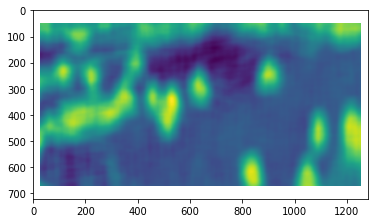

 42% (42 of 100) |#########              | Elapsed Time: 0:04:52 ETA:   0:05:58

SHAPES (137, 69, 3) (721, 1281, 3) (800, 306, 57, 74)
XYWH 800 306 57 74
SHAPES AFTER EXPAND (1, 137, 69, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 282ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


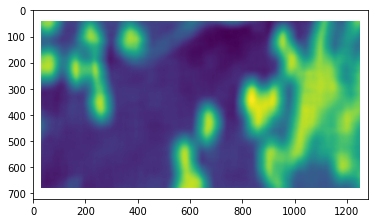

 43% (43 of 100) |#########              | Elapsed Time: 0:04:58 ETA:   0:05:50

SHAPES (58, 100, 3) (721, 1281, 3) (1032, 476, 96, 61)
XYWH 1032 476 96 61
SHAPES AFTER EXPAND (1, 58, 100, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 299ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


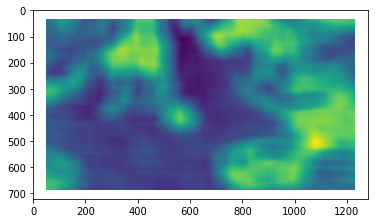

 44% (44 of 100) |##########             | Elapsed Time: 0:05:06 ETA:   0:07:55

SHAPES (103, 97, 3) (721, 1281, 3) (516, 268, 47, 90)
XYWH 516 268 47 90
SHAPES AFTER EXPAND (1, 103, 97, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 286ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


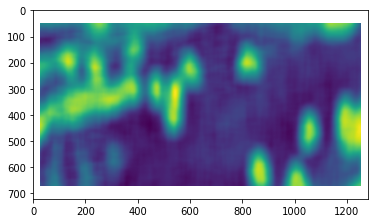

 45% (45 of 100) |##########             | Elapsed Time: 0:05:13 ETA:   0:05:38

SHAPES (66, 42, 3) (721, 1281, 3) (330, 21, 41, 68)
XYWH 330 21 41 68
SHAPES AFTER EXPAND (1, 66, 42, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 392ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


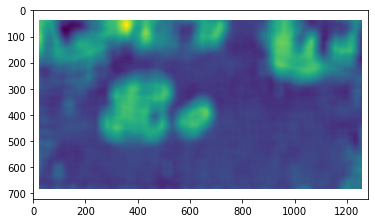

 46% (46 of 100) |##########             | Elapsed Time: 0:05:17 ETA:   0:03:58

SHAPES (32, 42, 3) (721, 1281, 3) (512, 311, 73, 45)
XYWH 512 311 73 45
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 290ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


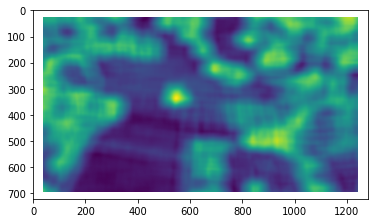

 47% (47 of 100) |##########             | Elapsed Time: 0:05:22 ETA:   0:04:17

SHAPES (59, 64, 3) (721, 1281, 3) (562, 229, 92, 58)
XYWH 562 229 92 58
SHAPES AFTER EXPAND (1, 59, 64, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 275ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


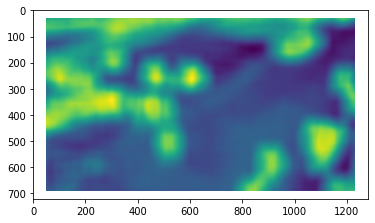

 48% (48 of 100) |###########            | Elapsed Time: 0:05:29 ETA:   0:06:38

SHAPES (65, 57, 3) (721, 1281, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 267ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


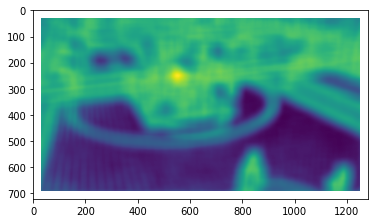

 49% (49 of 100) |###########            | Elapsed Time: 0:05:34 ETA:   0:03:49

SHAPES (118, 84, 3) (721, 1281, 3) (847, 296, 63, 94)
XYWH 847 296 63 94
SHAPES AFTER EXPAND (1, 118, 84, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 323ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


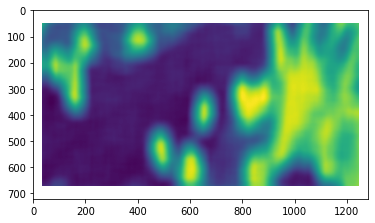

 50% (50 of 100) |###########            | Elapsed Time: 0:05:43 ETA:   0:07:44

SHAPES (32, 42, 3) (721, 1281, 3) (496, 290, 68, 45)
XYWH 496 290 68 45
SHAPES AFTER EXPAND (1, 32, 42, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 265ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


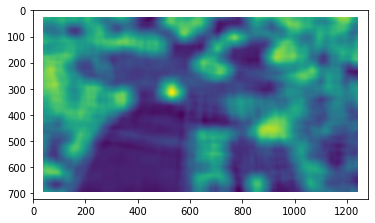

 51% (51 of 100) |###########            | Elapsed Time: 0:05:48 ETA:   0:03:44

SHAPES (43, 32, 3) (721, 1281, 3) (136, 673, 64, 47)
XYWH 136 673 64 47
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 281ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


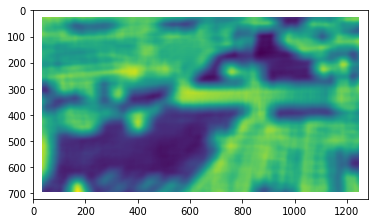

 52% (52 of 100) |###########            | Elapsed Time: 0:05:52 ETA:   0:03:39

SHAPES (128, 78, 3) (721, 1281, 3) (898, 270, 42, 85)
XYWH 898 270 42 85
SHAPES AFTER EXPAND (1, 128, 78, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 1s 640ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


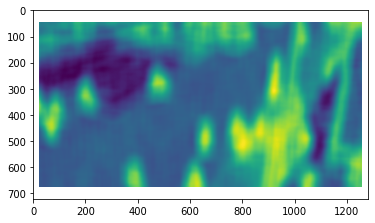

 53% (53 of 100) |############           | Elapsed Time: 0:05:58 ETA:   0:04:25

SHAPES (64, 84, 3) (721, 1281, 3) (456, 550, 87, 61)
XYWH 456 550 87 61
SHAPES AFTER EXPAND (1, 64, 84, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 289ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


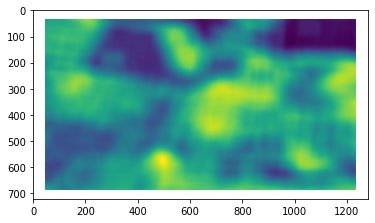

 54% (54 of 100) |############           | Elapsed Time: 0:06:06 ETA:   0:05:59

SHAPES (64, 84, 3) (721, 1281, 3) (441, 585, 97, 67)
XYWH 441 585 97 67
SHAPES AFTER EXPAND (1, 64, 84, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 278ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


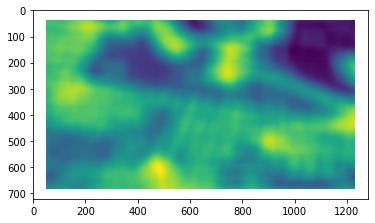

 55% (55 of 100) |############           | Elapsed Time: 0:06:16 ETA:   0:07:16

SHAPES (136, 69, 3) (721, 1281, 3) (961, 458, 66, 122)
XYWH 961 458 66 122
SHAPES AFTER EXPAND (1, 136, 69, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 285ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


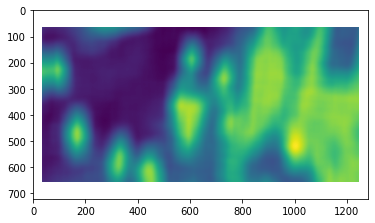

 56% (56 of 100) |############           | Elapsed Time: 0:06:27 ETA:   0:08:43

SHAPES (52, 25, 3) (721, 1281, 3) (736, 9, 21, 37)
XYWH 736 9 21 37
SHAPES AFTER EXPAND (1, 52, 25, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 375ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


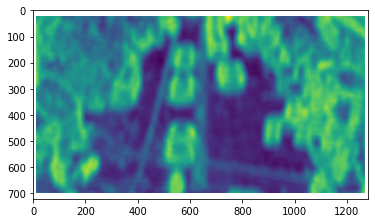

 56% (57 of 100) |#############          | Elapsed Time: 0:06:29 ETA:   0:04:53

SHAPES (61, 49, 3) (721, 1281, 3) (983, 123, 35, 59)
XYWH 983 123 35 59
SHAPES AFTER EXPAND (1, 61, 49, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 217ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


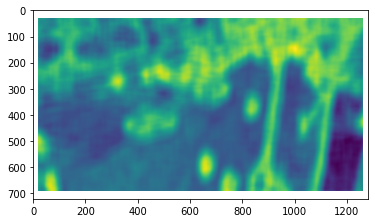

 57% (58 of 100) |#############          | Elapsed Time: 0:06:33 ETA:   0:02:17

SHAPES (43, 32, 3) (721, 1281, 3) (167, 637, 58, 62)
XYWH 167 637 58 62
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 300ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


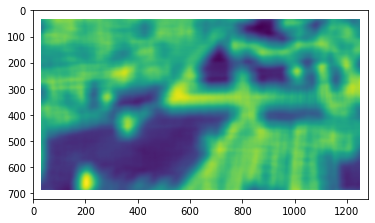

 59% (59 of 100) |#############          | Elapsed Time: 0:06:38 ETA:   0:03:45

SHAPES (50, 72, 3) (721, 1281, 3) (457, 199, 74, 50)
XYWH 457 199 74 50
SHAPES AFTER EXPAND (1, 50, 72, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 289ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


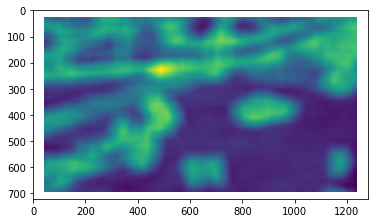

 60% (60 of 100) |#############          | Elapsed Time: 0:06:44 ETA:   0:03:40

SHAPES (101, 65, 3) (721, 1281, 3) (306, 270, 68, 53)
XYWH 306 270 68 53
SHAPES AFTER EXPAND (1, 101, 65, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 425ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


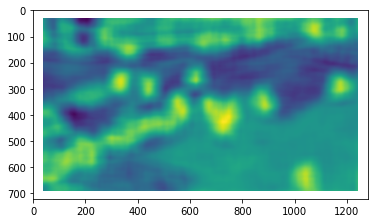

 61% (61 of 100) |##############         | Elapsed Time: 0:06:49 ETA:   0:03:35

SHAPES (43, 32, 3) (721, 1281, 3) (228, 587, 42, 56)
XYWH 228 587 42 56
SHAPES AFTER EXPAND (1, 43, 32, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 289ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


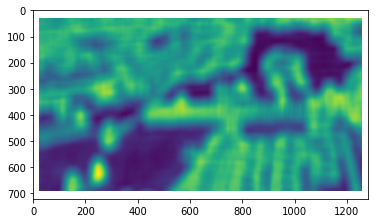

 62% (62 of 100) |##############         | Elapsed Time: 0:06:53 ETA:   0:02:20

SHAPES (65, 57, 3) (721, 1281, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 275ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


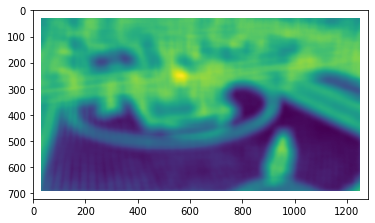

 63% (63 of 100) |##############         | Elapsed Time: 0:06:57 ETA:   0:02:44

SHAPES (65, 57, 3) (721, 1281, 3) (524, 222, 55, 53)
XYWH 524 222 55 53
SHAPES AFTER EXPAND (1, 65, 57, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 277ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


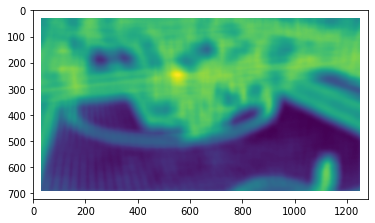

 64% (64 of 100) |##############         | Elapsed Time: 0:07:02 ETA:   0:02:37

SHAPES (45, 124, 3) (721, 1281, 3) (837, 233, 148, 61)
XYWH 837 233 148 61
SHAPES AFTER EXPAND (1, 45, 124, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 467ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


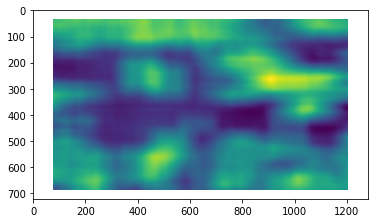

 65% (65 of 100) |##############         | Elapsed Time: 0:07:15 ETA:   0:07:50

SHAPES (72, 138, 3) (721, 1281, 3) (772, 471, 171, 58)
XYWH 772 471 171 58
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 1s 631ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


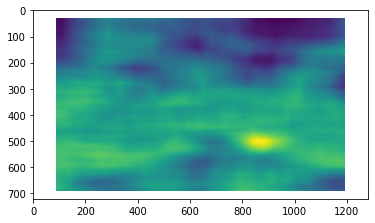

 66% (66 of 100) |###############        | Elapsed Time: 0:07:30 ETA:   0:08:28

SHAPES (115, 86, 3) (638, 1135, 3) (447, 410, 84, 118)
XYWH 447 410 84 118
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 638, 1135, 3)
W, H 638 1135
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (638, 1135)
SCORE SHAPE (638, 1135)


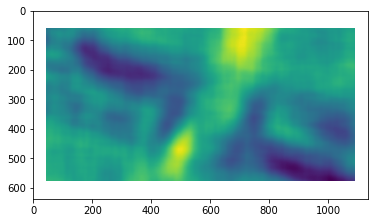

 67% (67 of 100) |###############        | Elapsed Time: 0:07:44 ETA:   0:07:36

SHAPES (115, 86, 3) (721, 1281, 3) (179, 149, 132, 75)
XYWH 179 149 132 75
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 317ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


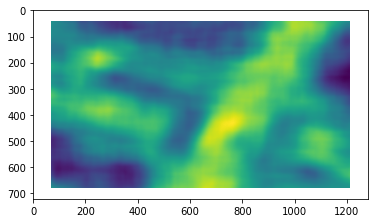

 68% (68 of 100) |###############        | Elapsed Time: 0:07:58 ETA:   0:07:41

SHAPES (115, 86, 3) (721, 1281, 3) (374, 223, 122, 81)
XYWH 374 223 122 81
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 322ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


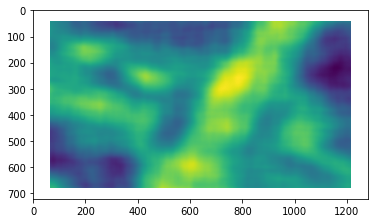

 69% (69 of 100) |###############        | Elapsed Time: 0:08:13 ETA:   0:07:25

SHAPES (103, 58, 3) (721, 1281, 3) (612, 315, 65, 114)
XYWH 612 315 65 114
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 419ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


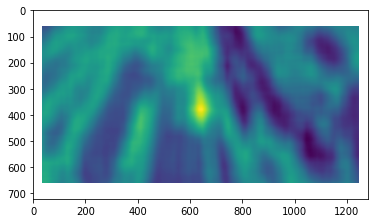

 70% (70 of 100) |################       | Elapsed Time: 0:08:24 ETA:   0:05:28

SHAPES (62, 159, 3) (681, 1211, 3) (260, 252, 160, 62)
XYWH 260 252 160 62
SHAPES AFTER EXPAND (1, 62, 159, 3) (1, 681, 1211, 3)
W, H 681 1211
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (681, 1211)
SCORE SHAPE (681, 1211)


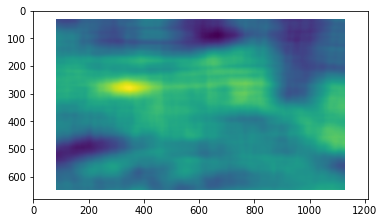

 71% (71 of 100) |################       | Elapsed Time: 0:08:39 ETA:   0:07:24

SHAPES (62, 159, 3) (664, 1181, 3) (173, 248, 164, 60)
XYWH 173 248 164 60
SHAPES AFTER EXPAND (1, 62, 159, 3) (1, 664, 1181, 3)
W, H 664 1181
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (664, 1181)
SCORE SHAPE (664, 1181)


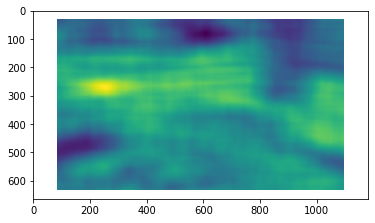

 72% (72 of 100) |################       | Elapsed Time: 0:08:53 ETA:   0:06:35

SHAPES (115, 86, 3) (630, 1121, 3) (401, 477, 83, 119)
XYWH 401 477 83 119
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 630, 1121, 3)
W, H 630 1121
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (630, 1121)
SCORE SHAPE (630, 1121)


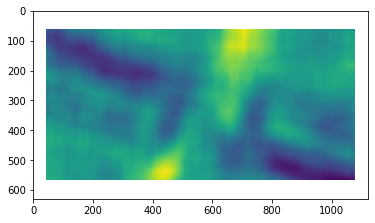

 73% (73 of 100) |################       | Elapsed Time: 0:09:06 ETA:   0:05:48

SHAPES (60, 165, 3) (721, 1281, 3) (120, 282, 178, 55)
XYWH 120 282 178 55
SHAPES AFTER EXPAND (1, 60, 165, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 1s 636ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


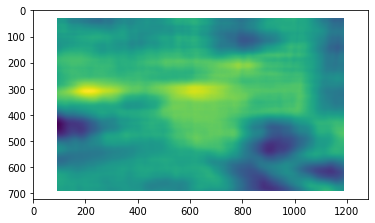

 74% (74 of 100) |#################      | Elapsed Time: 0:09:21 ETA:   0:06:22

SHAPES (120, 83, 3) (448, 796, 3) (464, 353, 106, 94)
XYWH 464 353 106 94
SHAPES AFTER EXPAND (1, 120, 83, 3) (1, 448, 796, 3)
W, H 448 796
1/1 [==============================] - 1s 1s/step
SALAM
SHAPE AFTER RESIZE (448, 796)
SCORE SHAPE (448, 796)


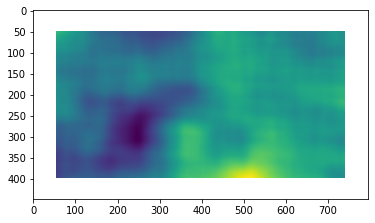

 75% (75 of 100) |#################      | Elapsed Time: 0:09:28 ETA:   0:03:15

SHAPES (120, 82, 3) (721, 1281, 3) (623, 205, 84, 117)
XYWH 623 205 84 117
SHAPES AFTER EXPAND (1, 120, 82, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 342ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


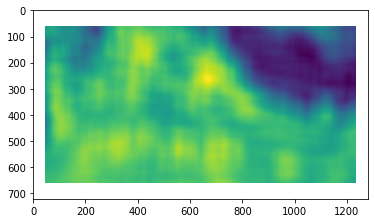

 76% (76 of 100) |#################      | Elapsed Time: 0:09:43 ETA:   0:05:45

SHAPES (62, 159, 3) (639, 1137, 3) (87, 241, 171, 58)
XYWH 87 241 171 58
SHAPES AFTER EXPAND (1, 62, 159, 3) (1, 639, 1137, 3)
W, H 639 1137
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (639, 1137)
SCORE SHAPE (639, 1137)


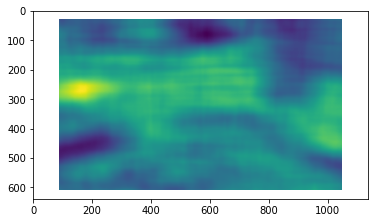

 77% (77 of 100) |#################      | Elapsed Time: 0:09:56 ETA:   0:05:06

SHAPES (56, 175, 3) (721, 1281, 3) (486, 405, 169, 59)
XYWH 486 405 169 59
SHAPES AFTER EXPAND (1, 56, 175, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 1s 630ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


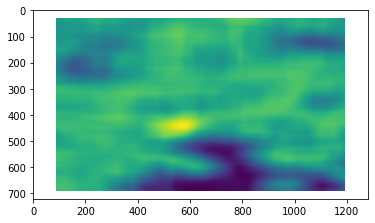

 78% (78 of 100) |#################      | Elapsed Time: 0:10:12 ETA:   0:05:48

SHAPES (83, 79, 3) (721, 1281, 3) (303, 84, 79, 83)
XYWH 303 84 79 83
SHAPES AFTER EXPAND (1, 83, 79, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 439ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


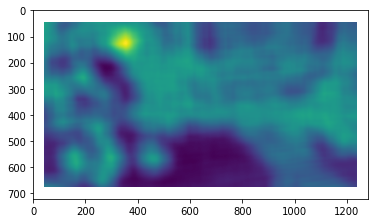

 79% (79 of 100) |##################     | Elapsed Time: 0:10:22 ETA:   0:03:22

SHAPES (60, 165, 3) (721, 1281, 3) (175, 282, 176, 56)
XYWH 175 282 176 56
SHAPES AFTER EXPAND (1, 60, 165, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 337ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


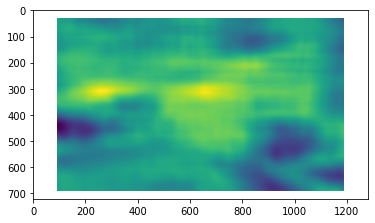

 80% (80 of 100) |##################     | Elapsed Time: 0:10:36 ETA:   0:04:51

SHAPES (72, 138, 3) (721, 1281, 3) (575, 460, 165, 60)
XYWH 575 460 165 60
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 288ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


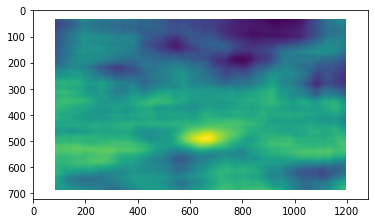

 81% (81 of 100) |##################     | Elapsed Time: 0:10:51 ETA:   0:04:37

SHAPES (72, 138, 3) (715, 1272, 3) (488, 456, 167, 59)
XYWH 488 456 167 59
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 715, 1272, 3)
W, H 715 1272
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (715, 1272)
SCORE SHAPE (715, 1272)


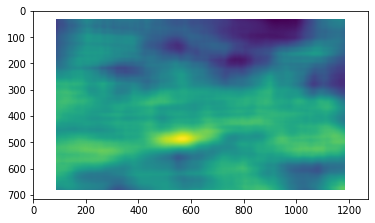

 82% (82 of 100) |##################     | Elapsed Time: 0:11:07 ETA:   0:04:48

SHAPES (120, 82, 3) (721, 1281, 3) (655, 263, 78, 127)
XYWH 655 263 78 127
SHAPES AFTER EXPAND (1, 120, 82, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 321ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


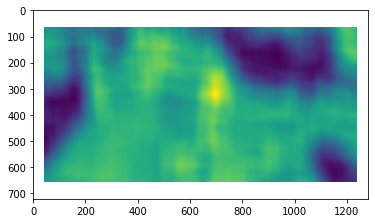

 83% (83 of 100) |###################    | Elapsed Time: 0:11:21 ETA:   0:04:07

SHAPES (62, 159, 3) (672, 1196, 3) (210, 250, 162, 61)
XYWH 210 250 162 61
SHAPES AFTER EXPAND (1, 62, 159, 3) (1, 672, 1196, 3)
W, H 672 1196
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (672, 1196)
SCORE SHAPE (672, 1196)


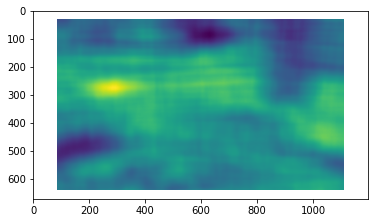

 84% (84 of 100) |###################    | Elapsed Time: 0:11:36 ETA:   0:03:52

SHAPES (103, 58, 3) (721, 1281, 3) (609, 311, 65, 114)
XYWH 609 311 65 114
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 312ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


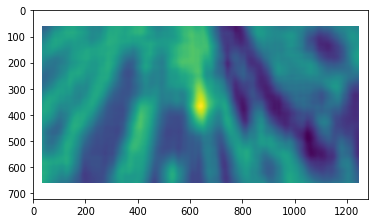

 85% (85 of 100) |###################    | Elapsed Time: 0:11:47 ETA:   0:02:41

SHAPES (26, 56, 3) (721, 1281, 3) (601, 184, 25, 27)
XYWH 601 184 25 27
SHAPES AFTER EXPAND (1, 26, 56, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 374ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


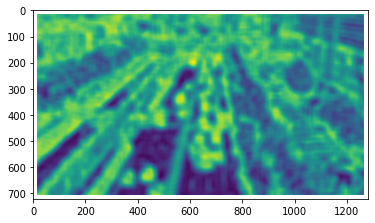

 86% (86 of 100) |###################    | Elapsed Time: 0:11:48 ETA:   0:01:26

SHAPES (120, 82, 3) (619, 1101, 3) (605, 295, 70, 142)
XYWH 605 295 70 142
SHAPES AFTER EXPAND (1, 120, 82, 3) (1, 619, 1101, 3)
W, H 619 1101
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (619, 1101)
SCORE SHAPE (619, 1101)


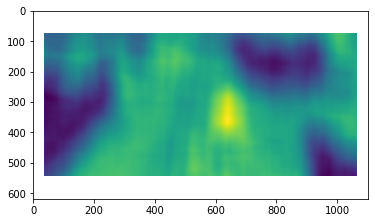

 87% (87 of 100) |####################   | Elapsed Time: 0:12:01 ETA:   0:02:42

SHAPES (88, 113, 3) (721, 1281, 3) (241, 173, 136, 73)
XYWH 241 173 136 73
SHAPES AFTER EXPAND (1, 88, 113, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 459ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


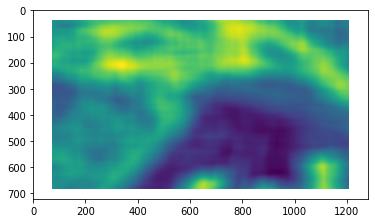

 88% (88 of 100) |####################   | Elapsed Time: 0:12:15 ETA:   0:02:54

SHAPES (72, 138, 3) (721, 1281, 3) (628, 464, 170, 58)
XYWH 628 464 170 58
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 285ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


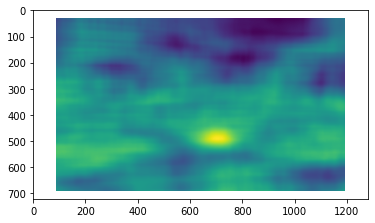

 89% (89 of 100) |####################   | Elapsed Time: 0:12:30 ETA:   0:02:40

SHAPES (62, 158, 3) (721, 1281, 3) (908, 408, 158, 63)
XYWH 908 408 158 63
SHAPES AFTER EXPAND (1, 62, 158, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 401ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


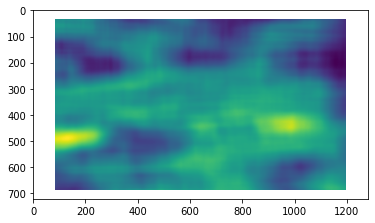

 90% (90 of 100) |####################   | Elapsed Time: 0:12:45 ETA:   0:02:32

SHAPES (103, 58, 3) (721, 1281, 3) (605, 308, 69, 114)
XYWH 605 308 69 114
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 301ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


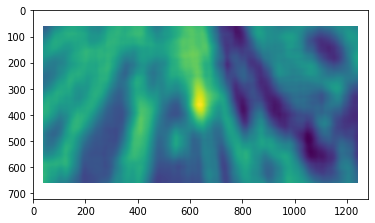

 91% (91 of 100) |####################   | Elapsed Time: 0:12:57 ETA:   0:01:42

SHAPES (83, 79, 3) (721, 1281, 3) (291, 83, 78, 83)
XYWH 291 83 78 83
SHAPES AFTER EXPAND (1, 83, 79, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 275ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


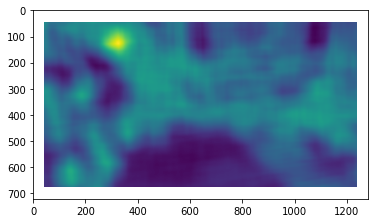

 92% (92 of 100) |#####################  | Elapsed Time: 0:13:06 ETA:   0:01:13

SHAPES (62, 158, 3) (721, 1281, 3) (978, 419, 164, 60)
XYWH 978 419 164 60
SHAPES AFTER EXPAND (1, 62, 158, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 331ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


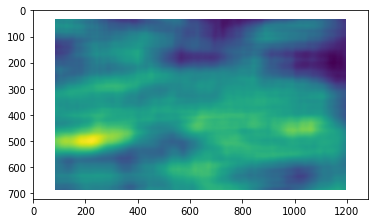

 93% (93 of 100) |#####################  | Elapsed Time: 0:13:20 ETA:   0:01:41

SHAPES (115, 86, 3) (721, 1281, 3) (38, 106, 137, 72)
XYWH 38 106 137 72
SHAPES AFTER EXPAND (1, 115, 86, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 308ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


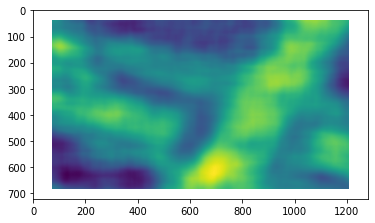

 94% (94 of 100) |#####################  | Elapsed Time: 0:13:35 ETA:   0:01:26

SHAPES (116, 85, 3) (721, 1281, 3) (213, 150, 131, 75)
XYWH 213 150 131 75
SHAPES AFTER EXPAND (1, 116, 85, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 388ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


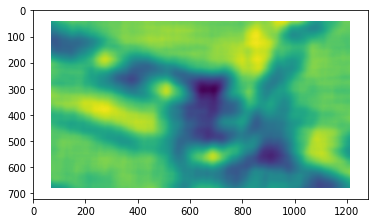

 95% (95 of 100) |#####################  | Elapsed Time: 0:13:49 ETA:   0:01:12

SHAPES (88, 113, 3) (721, 1281, 3) (324, 189, 141, 70)
XYWH 324 189 141 70
SHAPES AFTER EXPAND (1, 88, 113, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 291ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


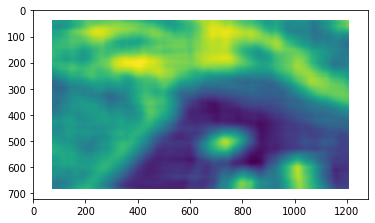

 96% (96 of 100) |###################### | Elapsed Time: 0:14:03 ETA:   0:00:57

SHAPES (72, 138, 3) (710, 1263, 3) (442, 452, 168, 59)
XYWH 442 452 168 59
SHAPES AFTER EXPAND (1, 72, 138, 3) (1, 710, 1263, 3)
W, H 710 1263
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (710, 1263)
SCORE SHAPE (710, 1263)


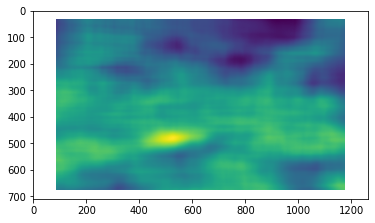

 97% (97 of 100) |###################### | Elapsed Time: 0:14:20 ETA:   0:00:48

SHAPES (96, 81, 3) (722, 1281, 3) (454, 134, 71, 104)
XYWH 454 134 71 104
SHAPES AFTER EXPAND (1, 96, 81, 3) (1, 722, 1281, 3)
W, H 722 1281
1/1 [==============================] - 2s 2s/step
SALAM
SHAPE AFTER RESIZE (722, 1281)
SCORE SHAPE (722, 1281)


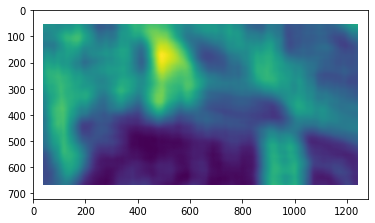

 98% (98 of 100) |###################### | Elapsed Time: 0:14:32 ETA:   0:00:24

SHAPES (96, 81, 3) (307, 545, 3) (86, 196, 90, 110)
XYWH 86 196 90 110
SHAPES AFTER EXPAND (1, 96, 81, 3) (1, 307, 545, 3)
W, H 307 545
1/1 [==============================] - 1s 674ms/step
SALAM
SHAPE AFTER RESIZE (307, 545)
SCORE SHAPE (307, 545)


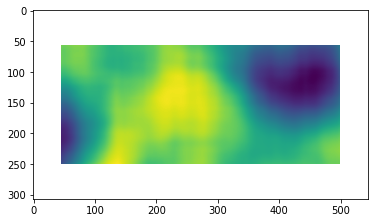

 99% (99 of 100) |###################### | Elapsed Time: 0:14:36 ETA:   0:00:04

SHAPES (103, 58, 3) (721, 1281, 3) (591, 318, 74, 89)
XYWH 591 318 74 89
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 285ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


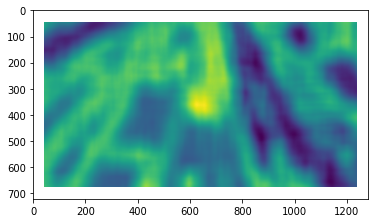

100% (100 of 100) |######################| Elapsed Time: 0:14:46 ETA:  00:00:00

SHAPES (103, 58, 3) (721, 1281, 3) (614, 313, 66, 114)
XYWH 614 313 66 114
SHAPES AFTER EXPAND (1, 103, 58, 3) (1, 721, 1281, 3)
W, H 721 1281
1/1 [==============================] - 0s 311ms/step
SALAM
SHAPE AFTER RESIZE (721, 1281)
SCORE SHAPE (721, 1281)


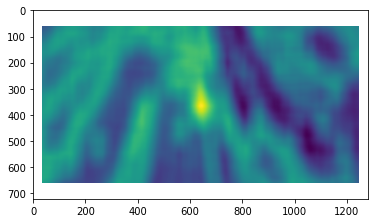

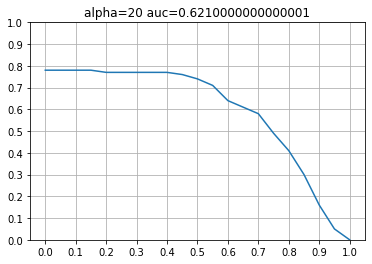

In [10]:
for k in [20]:
    score_list, gt_list, gray_list = model_eval( featex, alpha=k, backup=featex2)
    iou_score = all_sample_iou( score_list, gt_list )
    plot_success_curve( iou_score, title='alpha={} '.format(k) )